In [133]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re

In [134]:
train = pd.read_csv(r'../data/train.csv', index_col='id')
test = pd.read_csv(r'../data/test.csv', index_col='id')
submission = pd.read_csv(r'../data/submission.csv')

In [135]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [136]:
def lemmatize_and_stem(lemmatizer, stemmer, sentence):
    word_list = word_tokenize(sentence)
    output = ' '.join([stemmer.stem(lemmatizer.lemmatize(w)) for w in word_list])
    return output

In [137]:
def preprocess_text(sen):
    # To lower case
    sentence = sen.lower()
    
    # Removing html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Lemmatize and stem
    sentence = lemmatize_and_stem(WordNetLemmatizer(), PorterStemmer(), sentence)

    return sentence

In [138]:
X = []
sentences = list(train['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [139]:
X[0]

'action adventur billi clark is twenti year old veri pretti and without care in the world until brutal street gang violat her life and she turn into an alley cat bent on reveng when the gang attack her grandpar hous and her car billi us her black belt prowess to fight them off but at the same time she earn their hatr and she and her grandpar are mark for vengenc when her grandpar lose their life to the brutal thug billi becom like cat stalk her prey and no prison polic forc boyfriend or crook judg can get in the way of her aveng claw she a one woman vigilant squad martial art queen crack shot with no merci she the alley cat watch for the dramat end versu the gang leader rate for nuditi violenc other film with karin mani actress filmographi aveng angel jani soon lee from here to etern mini tv seri tawni filmographi a actress stunt filmographi aveng angel stunt s she should have been catwoman in the batman movi'

In [140]:
y = train['sentiment']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [142]:
# create a word-to-index dictionary
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [143]:
# find the vocabulary size and then perform padding on both train and test set
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [144]:
def epoch_accuarcy_loss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 32)           1860096   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,876,747
Trainable params: 1,876,747
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
198/198 [==============================] - 23s 116ms/step - loss: 0.5287 - accuracy: 0.7245 - val_loss: 0.3737 - val_accuracy: 0.8416
Epoch 2/6
198/198 [==============================] - 23s 117ms/step - loss: 0.3399 - accuracy: 0.8597 - val_loss: 0.3538 - val_accuracy: 0.8547
Epoch 3/6
198/198 [==============================] - 24s 120ms/step - loss: 0.2789 - accuracy: 0.8877 - val_loss: 0.3396 - val_accuracy: 0.8565
Epoch 4/6
198/198 [==============================] - 24s 121ms/step - loss: 0.2437 - accuracy: 0.9049 - val_loss: 0.3750 - val_accuracy: 0.8550
Epoch 5/6
198/198 [==============================] - 24s 119ms/step - loss: 0.2278 - accuracy: 0.9135 - val_loss: 0.3824 - val_accuracy: 0.8501
Epoch 6/6
248/248 [==============================] - 2s 9ms/step - loss: 0.4018 - accuracy: 0.8498


In [147]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4018411338329315
Test Accuracy: 0.8498168587684631


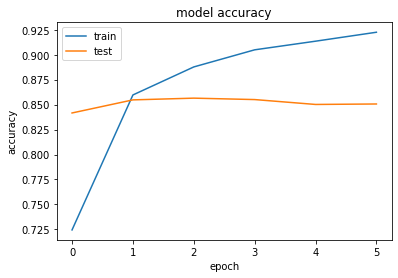

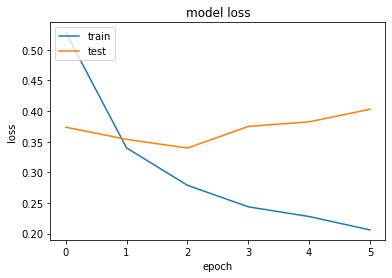

In [148]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()